In [1]:
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.datasets import FashionMNIST
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from PIL import Image

# 加载数据集

In [2]:
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [3]:
trainset = FashionMNIST('.', train=True, transform=data_transform, download=True)
testset = FashionMNIST('.', train=False, transform=data_transform, download=True)

# 定义网络

In [4]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.dropout = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(64*7*7, 128)
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x):
        in_size = x.shape[0]
        # x: batch_size*1*28*28
        x = self.conv1(x)   # x: batch_size*32*28*28
        x = self.maxpool(x) # x: batch_size*32*14*14
        x = F.relu(x)
        
        x = self.conv2(x)   # x: batch_size*64*14*14
        x = self.maxpool(x) # x: batch_size*64*7*7
        x = F.relu(x)
        
        x = x.view(in_size, -1) # x: batch_size*3136
        x = self.dropout(x)
        x = F.relu(self.fc1(x)) # x: batch_size*128
        x = self.fc2(x)         # x: batch_size*10
        return x

# 超参数 loss 优化器

In [6]:
# Batch Norm增加收敛速度
class CNNBatchNorm(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.dropout = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(64*7*7, 128)
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x):
        in_size = x.shape[0]
        # x: batch_size*1*28*28
        x = self.conv1(x)   # x: batch_size*32*28*28
        x = self.maxpool(x) # x: batch_size*32*14*14
        x = self.bn1(x)
        x = F.relu(x)
        
        x = self.conv2(x)   # x: batch_size*64*14*14
        x = self.maxpool(x) # x: batch_size*64*7*7
        x = self.bn2(x)
        x = F.relu(x)
        
        x = x.view(in_size, -1) # x: batch_size*320
        x = self.dropout(x)
        x = F.relu(self.fc1(x))      # x: batch_size*10
        x = self.fc2(x)
        return x

In [7]:
def train(epoch):
    print('training......')
    net.train()
    batch_num = len(trainloader)
    for step, data in enumerate(trainloader):
        img, label = data
        if torch.cuda.is_available():
            img = img.cuda()
            label = label.cuda()

        out = net(img)
        loss = criterion(out, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if step % 100 == 0:
            print_loss = loss.data.item()
            train_loss.append(print_loss)
            print('epoch: {}, batch: {}/{}, loss: {:.4}'.format(epoch, step, batch_num, print_loss))

In [8]:
def test():
    print('testing......')
    net.eval()
    eval_loss = 0
    eval_acc = 0
    for data in tqdm(testloader):
        img, label = data
        if torch.cuda.is_available():
            img = img.cuda()
            label = label.cuda()
        out = net(img)
        loss = criterion(out, label)
        eval_loss += loss.data.item()*label.size(0)
        _, pred = torch.max(out, 1)
        num_correct = (pred == label).sum()
        eval_acc += num_correct.item()
    print('Test Loss: {:.6f}, Acc: {:.6f}'.format(
        eval_loss/(len(testset)),                  
        eval_acc/(len(testset))
    ))

In [9]:
batch_size = 64
num_epoches = 20

In [10]:
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

In [11]:
net = CNN()
if torch.cuda.is_available():
    print('使用GPU')
    net = net.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

使用GPU


training......
epoch: 0, batch: 0/938, loss: 2.294
epoch: 0, batch: 100/938, loss: 0.7161
epoch: 0, batch: 200/938, loss: 0.4773
epoch: 0, batch: 300/938, loss: 0.4642
epoch: 0, batch: 400/938, loss: 0.4013
epoch: 0, batch: 500/938, loss: 0.2711
epoch: 0, batch: 600/938, loss: 0.3862
epoch: 0, batch: 700/938, loss: 0.6274
epoch: 0, batch: 800/938, loss: 0.3685
epoch: 0, batch: 900/938, loss: 0.2391
testing......



Test Loss: 0.333541, Acc: 0.879400
training......
epoch: 1, batch: 0/938, loss: 0.3158
epoch: 1, batch: 100/938, loss: 0.4422
epoch: 1, batch: 200/938, loss: 0.4804
epoch: 1, batch: 300/938, loss: 0.524
epoch: 1, batch: 400/938, loss: 0.1888
epoch: 1, batch: 500/938, loss: 0.3928
epoch: 1, batch: 600/938, loss: 0.2075
epoch: 1, batch: 700/938, loss: 0.1394
epoch: 1, batch: 800/938, loss: 0.22
epoch: 1, batch: 900/938, loss: 0.3883
testing......



Test Loss: 0.277853, Acc: 0.898800
training......
epoch: 2, batch: 0/938, loss: 0.4975
epoch: 2, batch: 100/938, loss: 0.3506
epoch: 2, batch: 200/938, loss: 0.2
epoch: 2, batch: 300/938, loss: 0.1569
epoch: 2, batch: 400/938, loss: 0.2717
epoch: 2, batch: 500/938, loss: 0.2427
epoch: 2, batch: 600/938, loss: 0.2793
epoch: 2, batch: 700/938, loss: 0.3079
epoch: 2, batch: 800/938, loss: 0.2474
epoch: 2, batch: 900/938, loss: 0.2541
testing......



Test Loss: 0.270732, Acc: 0.899200
training......
epoch: 3, batch: 0/938, loss: 0.1859
epoch: 3, batch: 100/938, loss: 0.1201
epoch: 3, batch: 200/938, loss: 0.3188
epoch: 3, batch: 300/938, loss: 0.1937
epoch: 3, batch: 400/938, loss: 0.1397
epoch: 3, batch: 500/938, loss: 0.4369
epoch: 3, batch: 600/938, loss: 0.194
epoch: 3, batch: 700/938, loss: 0.1367
epoch: 3, batch: 800/938, loss: 0.177
epoch: 3, batch: 900/938, loss: 0.2647
testing......



Test Loss: 0.244917, Acc: 0.910500
training......
epoch: 4, batch: 0/938, loss: 0.2733
epoch: 4, batch: 100/938, loss: 0.2701
epoch: 4, batch: 200/938, loss: 0.287
epoch: 4, batch: 300/938, loss: 0.2203
epoch: 4, batch: 400/938, loss: 0.09285
epoch: 4, batch: 500/938, loss: 0.2125
epoch: 4, batch: 600/938, loss: 0.1701
epoch: 4, batch: 700/938, loss: 0.4181
epoch: 4, batch: 800/938, loss: 0.1218
epoch: 4, batch: 900/938, loss: 0.1797
testing......



Test Loss: 0.233683, Acc: 0.911400
training......
epoch: 5, batch: 0/938, loss: 0.2925
epoch: 5, batch: 100/938, loss: 0.2199
epoch: 5, batch: 200/938, loss: 0.3213
epoch: 5, batch: 300/938, loss: 0.2159
epoch: 5, batch: 400/938, loss: 0.2589
epoch: 5, batch: 500/938, loss: 0.2753
epoch: 5, batch: 600/938, loss: 0.2026
epoch: 5, batch: 700/938, loss: 0.3402
epoch: 5, batch: 800/938, loss: 0.1839
epoch: 5, batch: 900/938, loss: 0.2054
testing......



Test Loss: 0.238010, Acc: 0.912800
training......
epoch: 6, batch: 0/938, loss: 0.3023
epoch: 6, batch: 100/938, loss: 0.1286
epoch: 6, batch: 200/938, loss: 0.1964
epoch: 6, batch: 300/938, loss: 0.179
epoch: 6, batch: 400/938, loss: 0.1943
epoch: 6, batch: 500/938, loss: 0.1594
epoch: 6, batch: 600/938, loss: 0.1736
epoch: 6, batch: 700/938, loss: 0.1427
epoch: 6, batch: 800/938, loss: 0.1013
epoch: 6, batch: 900/938, loss: 0.1925
testing......



Test Loss: 0.221512, Acc: 0.918300
training......
epoch: 7, batch: 0/938, loss: 0.1554
epoch: 7, batch: 100/938, loss: 0.228
epoch: 7, batch: 200/938, loss: 0.1547
epoch: 7, batch: 300/938, loss: 0.2481
epoch: 7, batch: 400/938, loss: 0.1957
epoch: 7, batch: 500/938, loss: 0.09197
epoch: 7, batch: 600/938, loss: 0.307
epoch: 7, batch: 700/938, loss: 0.1381
epoch: 7, batch: 800/938, loss: 0.04268
epoch: 7, batch: 900/938, loss: 0.2593
testing......



Test Loss: 0.222032, Acc: 0.922200
training......
epoch: 8, batch: 0/938, loss: 0.2756
epoch: 8, batch: 100/938, loss: 0.1288
epoch: 8, batch: 200/938, loss: 0.2252
epoch: 8, batch: 300/938, loss: 0.06486
epoch: 8, batch: 400/938, loss: 0.2196
epoch: 8, batch: 500/938, loss: 0.09625
epoch: 8, batch: 600/938, loss: 0.2385
epoch: 8, batch: 700/938, loss: 0.2336
epoch: 8, batch: 800/938, loss: 0.1271
epoch: 8, batch: 900/938, loss: 0.1961
testing......



Test Loss: 0.218572, Acc: 0.918800
training......
epoch: 9, batch: 0/938, loss: 0.2015
epoch: 9, batch: 100/938, loss: 0.1178
epoch: 9, batch: 200/938, loss: 0.08796
epoch: 9, batch: 300/938, loss: 0.06724
epoch: 9, batch: 400/938, loss: 0.09679
epoch: 9, batch: 500/938, loss: 0.08196
epoch: 9, batch: 600/938, loss: 0.1634
epoch: 9, batch: 700/938, loss: 0.3132
epoch: 9, batch: 800/938, loss: 0.1842
epoch: 9, batch: 900/938, loss: 0.1807
testing......



Test Loss: 0.210128, Acc: 0.924000
training......
epoch: 10, batch: 0/938, loss: 0.1531
epoch: 10, batch: 100/938, loss: 0.06066
epoch: 10, batch: 200/938, loss: 0.09473
epoch: 10, batch: 300/938, loss: 0.2028
epoch: 10, batch: 400/938, loss: 0.1794
epoch: 10, batch: 500/938, loss: 0.1555
epoch: 10, batch: 600/938, loss: 0.1904
epoch: 10, batch: 700/938, loss: 0.1947
epoch: 10, batch: 800/938, loss: 0.1365
epoch: 10, batch: 900/938, loss: 0.0662
testing......



Test Loss: 0.217875, Acc: 0.923300
training......
epoch: 11, batch: 0/938, loss: 0.1039
epoch: 11, batch: 100/938, loss: 0.08055
epoch: 11, batch: 200/938, loss: 0.05224
epoch: 11, batch: 300/938, loss: 0.133
epoch: 11, batch: 400/938, loss: 0.2127
epoch: 11, batch: 500/938, loss: 0.2176
epoch: 11, batch: 600/938, loss: 0.07701
epoch: 11, batch: 700/938, loss: 0.0977
epoch: 11, batch: 800/938, loss: 0.2065
epoch: 11, batch: 900/938, loss: 0.2336
testing......



Test Loss: 0.217435, Acc: 0.925800
training......
epoch: 12, batch: 0/938, loss: 0.0508
epoch: 12, batch: 100/938, loss: 0.107
epoch: 12, batch: 200/938, loss: 0.1247
epoch: 12, batch: 300/938, loss: 0.1331
epoch: 12, batch: 400/938, loss: 0.1707
epoch: 12, batch: 500/938, loss: 0.1966
epoch: 12, batch: 600/938, loss: 0.1349
epoch: 12, batch: 700/938, loss: 0.1195
epoch: 12, batch: 800/938, loss: 0.2111
epoch: 12, batch: 900/938, loss: 0.2976
testing......



Test Loss: 0.220360, Acc: 0.925100
training......
epoch: 13, batch: 0/938, loss: 0.1017
epoch: 13, batch: 100/938, loss: 0.06776
epoch: 13, batch: 200/938, loss: 0.1482
epoch: 13, batch: 300/938, loss: 0.04397
epoch: 13, batch: 400/938, loss: 0.1831
epoch: 13, batch: 500/938, loss: 0.1446
epoch: 13, batch: 600/938, loss: 0.191
epoch: 13, batch: 700/938, loss: 0.08547
epoch: 13, batch: 800/938, loss: 0.1417
epoch: 13, batch: 900/938, loss: 0.1054
testing......



Test Loss: 0.221979, Acc: 0.924900
training......
epoch: 14, batch: 0/938, loss: 0.2035
epoch: 14, batch: 100/938, loss: 0.2488
epoch: 14, batch: 200/938, loss: 0.1366
epoch: 14, batch: 300/938, loss: 0.09541
epoch: 14, batch: 400/938, loss: 0.1275
epoch: 14, batch: 500/938, loss: 0.1427
epoch: 14, batch: 600/938, loss: 0.05757
epoch: 14, batch: 700/938, loss: 0.1309
epoch: 14, batch: 800/938, loss: 0.1999
epoch: 14, batch: 900/938, loss: 0.2786
testing......



Test Loss: 0.217092, Acc: 0.924500
training......
epoch: 15, batch: 0/938, loss: 0.07942
epoch: 15, batch: 100/938, loss: 0.0879
epoch: 15, batch: 200/938, loss: 0.1409
epoch: 15, batch: 300/938, loss: 0.1138
epoch: 15, batch: 400/938, loss: 0.07566
epoch: 15, batch: 500/938, loss: 0.1478
epoch: 15, batch: 600/938, loss: 0.1093
epoch: 15, batch: 700/938, loss: 0.1143
epoch: 15, batch: 800/938, loss: 0.1148
epoch: 15, batch: 900/938, loss: 0.06915
testing......



Test Loss: 0.223852, Acc: 0.925500
training......
epoch: 16, batch: 0/938, loss: 0.08727
epoch: 16, batch: 100/938, loss: 0.1045
epoch: 16, batch: 200/938, loss: 0.1156
epoch: 16, batch: 300/938, loss: 0.03331
epoch: 16, batch: 400/938, loss: 0.09301
epoch: 16, batch: 500/938, loss: 0.05278
epoch: 16, batch: 600/938, loss: 0.11
epoch: 16, batch: 700/938, loss: 0.1058
epoch: 16, batch: 800/938, loss: 0.0606
epoch: 16, batch: 900/938, loss: 0.1516
testing......



Test Loss: 0.218641, Acc: 0.928800
training......
epoch: 17, batch: 0/938, loss: 0.08786
epoch: 17, batch: 100/938, loss: 0.2272
epoch: 17, batch: 200/938, loss: 0.1516
epoch: 17, batch: 300/938, loss: 0.07837
epoch: 17, batch: 400/938, loss: 0.02691
epoch: 17, batch: 500/938, loss: 0.3124
epoch: 17, batch: 600/938, loss: 0.1261
epoch: 17, batch: 700/938, loss: 0.03381
epoch: 17, batch: 800/938, loss: 0.1173
epoch: 17, batch: 900/938, loss: 0.08186
testing......



Test Loss: 0.225467, Acc: 0.926900
training......
epoch: 18, batch: 0/938, loss: 0.1629
epoch: 18, batch: 100/938, loss: 0.06707
epoch: 18, batch: 200/938, loss: 0.1388
epoch: 18, batch: 300/938, loss: 0.1274
epoch: 18, batch: 400/938, loss: 0.05318
epoch: 18, batch: 500/938, loss: 0.1233
epoch: 18, batch: 600/938, loss: 0.09246
epoch: 18, batch: 700/938, loss: 0.0612
epoch: 18, batch: 800/938, loss: 0.07417
epoch: 18, batch: 900/938, loss: 0.1256
testing......



Test Loss: 0.218907, Acc: 0.930800
training......
epoch: 19, batch: 0/938, loss: 0.1013
epoch: 19, batch: 100/938, loss: 0.06288
epoch: 19, batch: 200/938, loss: 0.117
epoch: 19, batch: 300/938, loss: 0.194
epoch: 19, batch: 400/938, loss: 0.1174
epoch: 19, batch: 500/938, loss: 0.1105
epoch: 19, batch: 600/938, loss: 0.1814
epoch: 19, batch: 700/938, loss: 0.05442
epoch: 19, batch: 800/938, loss: 0.08888
epoch: 19, batch: 900/938, loss: 0.2239
testing......



Test Loss: 0.233183, Acc: 0.926200


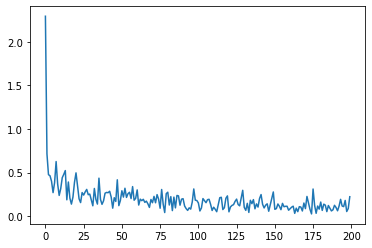

In [12]:
train_loss = []
for epoch in range(num_epoches):
    train(epoch)
    test()
plt.plot(train_loss)

In [13]:
net = CNNBatchNorm()
if torch.cuda.is_available():
    print('使用GPU')
    net = net.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

使用GPU


training......
epoch: 0, batch: 0/938, loss: 2.274
epoch: 0, batch: 100/938, loss: 0.5193
epoch: 0, batch: 200/938, loss: 0.3476
epoch: 0, batch: 300/938, loss: 0.5253
epoch: 0, batch: 400/938, loss: 0.1872
epoch: 0, batch: 500/938, loss: 0.2984
epoch: 0, batch: 600/938, loss: 0.206
epoch: 0, batch: 700/938, loss: 0.5113
epoch: 0, batch: 800/938, loss: 0.3198
epoch: 0, batch: 900/938, loss: 0.1876
testing......



Test Loss: 0.297766, Acc: 0.886900
training......
epoch: 1, batch: 0/938, loss: 0.2779
epoch: 1, batch: 100/938, loss: 0.2204
epoch: 1, batch: 200/938, loss: 0.3452
epoch: 1, batch: 300/938, loss: 0.2764
epoch: 1, batch: 400/938, loss: 0.3644
epoch: 1, batch: 500/938, loss: 0.1916
epoch: 1, batch: 600/938, loss: 0.2471
epoch: 1, batch: 700/938, loss: 0.3386
epoch: 1, batch: 800/938, loss: 0.3366
epoch: 1, batch: 900/938, loss: 0.3912
testing......



Test Loss: 0.269861, Acc: 0.899500
training......
epoch: 2, batch: 0/938, loss: 0.3059
epoch: 2, batch: 100/938, loss: 0.269
epoch: 2, batch: 200/938, loss: 0.284
epoch: 2, batch: 300/938, loss: 0.2362
epoch: 2, batch: 400/938, loss: 0.3446
epoch: 2, batch: 500/938, loss: 0.2683
epoch: 2, batch: 600/938, loss: 0.2576
epoch: 2, batch: 700/938, loss: 0.3044
epoch: 2, batch: 800/938, loss: 0.2407
epoch: 2, batch: 900/938, loss: 0.2233
testing......



Test Loss: 0.249356, Acc: 0.910300
training......
epoch: 3, batch: 0/938, loss: 0.06484
epoch: 3, batch: 100/938, loss: 0.2548
epoch: 3, batch: 200/938, loss: 0.2486
epoch: 3, batch: 300/938, loss: 0.3863
epoch: 3, batch: 400/938, loss: 0.2393
epoch: 3, batch: 500/938, loss: 0.2116
epoch: 3, batch: 600/938, loss: 0.2118
epoch: 3, batch: 700/938, loss: 0.2968
epoch: 3, batch: 800/938, loss: 0.2551
epoch: 3, batch: 900/938, loss: 0.3131
testing......



Test Loss: 0.236586, Acc: 0.914600
training......
epoch: 4, batch: 0/938, loss: 0.1389
epoch: 4, batch: 100/938, loss: 0.3622
epoch: 4, batch: 200/938, loss: 0.225
epoch: 4, batch: 300/938, loss: 0.1391
epoch: 4, batch: 400/938, loss: 0.09553
epoch: 4, batch: 500/938, loss: 0.1939
epoch: 4, batch: 600/938, loss: 0.07927
epoch: 4, batch: 700/938, loss: 0.3832
epoch: 4, batch: 800/938, loss: 0.3623
epoch: 4, batch: 900/938, loss: 0.1958
testing......



Test Loss: 0.239665, Acc: 0.912800
training......
epoch: 5, batch: 0/938, loss: 0.2851
epoch: 5, batch: 100/938, loss: 0.1313
epoch: 5, batch: 200/938, loss: 0.2461
epoch: 5, batch: 300/938, loss: 0.2659
epoch: 5, batch: 400/938, loss: 0.1328
epoch: 5, batch: 500/938, loss: 0.1575
epoch: 5, batch: 600/938, loss: 0.1057
epoch: 5, batch: 700/938, loss: 0.3172
epoch: 5, batch: 800/938, loss: 0.1434
epoch: 5, batch: 900/938, loss: 0.4867
testing......



Test Loss: 0.230681, Acc: 0.915600
training......
epoch: 6, batch: 0/938, loss: 0.2107
epoch: 6, batch: 100/938, loss: 0.1666
epoch: 6, batch: 200/938, loss: 0.1724
epoch: 6, batch: 300/938, loss: 0.1716
epoch: 6, batch: 400/938, loss: 0.2212
epoch: 6, batch: 500/938, loss: 0.1862
epoch: 6, batch: 600/938, loss: 0.2782
epoch: 6, batch: 700/938, loss: 0.1904
epoch: 6, batch: 800/938, loss: 0.2664
epoch: 6, batch: 900/938, loss: 0.3028
testing......



Test Loss: 0.220542, Acc: 0.921900
training......
epoch: 7, batch: 0/938, loss: 0.1605
epoch: 7, batch: 100/938, loss: 0.0768
epoch: 7, batch: 200/938, loss: 0.116
epoch: 7, batch: 300/938, loss: 0.1435
epoch: 7, batch: 400/938, loss: 0.4044
epoch: 7, batch: 500/938, loss: 0.1944
epoch: 7, batch: 600/938, loss: 0.1699
epoch: 7, batch: 700/938, loss: 0.1412
epoch: 7, batch: 800/938, loss: 0.2238
epoch: 7, batch: 900/938, loss: 0.09562
testing......



Test Loss: 0.228220, Acc: 0.919500
training......
epoch: 8, batch: 0/938, loss: 0.142
epoch: 8, batch: 100/938, loss: 0.2192
epoch: 8, batch: 200/938, loss: 0.1938
epoch: 8, batch: 300/938, loss: 0.1467
epoch: 8, batch: 400/938, loss: 0.2707
epoch: 8, batch: 500/938, loss: 0.2861
epoch: 8, batch: 600/938, loss: 0.1432
epoch: 8, batch: 700/938, loss: 0.2555
epoch: 8, batch: 800/938, loss: 0.1212
epoch: 8, batch: 900/938, loss: 0.09744
testing......



Test Loss: 0.228749, Acc: 0.922300
training......
epoch: 9, batch: 0/938, loss: 0.06202
epoch: 9, batch: 100/938, loss: 0.1033
epoch: 9, batch: 200/938, loss: 0.1202
epoch: 9, batch: 300/938, loss: 0.1323
epoch: 9, batch: 400/938, loss: 0.196
epoch: 9, batch: 500/938, loss: 0.1716
epoch: 9, batch: 600/938, loss: 0.1467
epoch: 9, batch: 700/938, loss: 0.1508
epoch: 9, batch: 800/938, loss: 0.1632
epoch: 9, batch: 900/938, loss: 0.1062
testing......



Test Loss: 0.225251, Acc: 0.921800
training......
epoch: 10, batch: 0/938, loss: 0.07663
epoch: 10, batch: 100/938, loss: 0.09486
epoch: 10, batch: 200/938, loss: 0.2385
epoch: 10, batch: 300/938, loss: 0.1727
epoch: 10, batch: 400/938, loss: 0.1836
epoch: 10, batch: 500/938, loss: 0.1951
epoch: 10, batch: 600/938, loss: 0.1396
epoch: 10, batch: 700/938, loss: 0.1919
epoch: 10, batch: 800/938, loss: 0.2314
epoch: 10, batch: 900/938, loss: 0.2035
testing......



Test Loss: 0.219090, Acc: 0.925700
training......
epoch: 11, batch: 0/938, loss: 0.2195
epoch: 11, batch: 100/938, loss: 0.1071
epoch: 11, batch: 200/938, loss: 0.08571
epoch: 11, batch: 300/938, loss: 0.1724
epoch: 11, batch: 400/938, loss: 0.1072
epoch: 11, batch: 500/938, loss: 0.09267
epoch: 11, batch: 600/938, loss: 0.1075
epoch: 11, batch: 700/938, loss: 0.02508
epoch: 11, batch: 800/938, loss: 0.1254
epoch: 11, batch: 900/938, loss: 0.2974
testing......



Test Loss: 0.217204, Acc: 0.928200
training......
epoch: 12, batch: 0/938, loss: 0.1208
epoch: 12, batch: 100/938, loss: 0.1105
epoch: 12, batch: 200/938, loss: 0.1366
epoch: 12, batch: 300/938, loss: 0.1656
epoch: 12, batch: 400/938, loss: 0.2164
epoch: 12, batch: 500/938, loss: 0.1242
epoch: 12, batch: 600/938, loss: 0.1217
epoch: 12, batch: 700/938, loss: 0.03357
epoch: 12, batch: 800/938, loss: 0.1433
epoch: 12, batch: 900/938, loss: 0.06896
testing......



Test Loss: 0.234895, Acc: 0.925800
training......
epoch: 13, batch: 0/938, loss: 0.05126
epoch: 13, batch: 100/938, loss: 0.1972
epoch: 13, batch: 200/938, loss: 0.1387
epoch: 13, batch: 300/938, loss: 0.04019
epoch: 13, batch: 400/938, loss: 0.1232
epoch: 13, batch: 500/938, loss: 0.1806
epoch: 13, batch: 600/938, loss: 0.1112
epoch: 13, batch: 700/938, loss: 0.1295
epoch: 13, batch: 800/938, loss: 0.04963
epoch: 13, batch: 900/938, loss: 0.1423
testing......



Test Loss: 0.236465, Acc: 0.924100
training......
epoch: 14, batch: 0/938, loss: 0.1352
epoch: 14, batch: 100/938, loss: 0.05283
epoch: 14, batch: 200/938, loss: 0.1126
epoch: 14, batch: 300/938, loss: 0.03015
epoch: 14, batch: 400/938, loss: 0.228
epoch: 14, batch: 500/938, loss: 0.06121
epoch: 14, batch: 600/938, loss: 0.1047
epoch: 14, batch: 700/938, loss: 0.1029
epoch: 14, batch: 800/938, loss: 0.07376
epoch: 14, batch: 900/938, loss: 0.09993
testing......



Test Loss: 0.233404, Acc: 0.926700
training......
epoch: 15, batch: 0/938, loss: 0.06919
epoch: 15, batch: 100/938, loss: 0.1584
epoch: 15, batch: 200/938, loss: 0.1409
epoch: 15, batch: 300/938, loss: 0.1512
epoch: 15, batch: 400/938, loss: 0.1429
epoch: 15, batch: 500/938, loss: 0.04419
epoch: 15, batch: 600/938, loss: 0.03978
epoch: 15, batch: 700/938, loss: 0.2106
epoch: 15, batch: 800/938, loss: 0.02978
epoch: 15, batch: 900/938, loss: 0.161
testing......



Test Loss: 0.238705, Acc: 0.922300
training......
epoch: 16, batch: 0/938, loss: 0.1202
epoch: 16, batch: 100/938, loss: 0.1662
epoch: 16, batch: 200/938, loss: 0.1489
epoch: 16, batch: 300/938, loss: 0.1074
epoch: 16, batch: 400/938, loss: 0.09427
epoch: 16, batch: 500/938, loss: 0.07701
epoch: 16, batch: 600/938, loss: 0.2779
epoch: 16, batch: 700/938, loss: 0.1261
epoch: 16, batch: 800/938, loss: 0.06427
epoch: 16, batch: 900/938, loss: 0.09645
testing......



Test Loss: 0.240909, Acc: 0.926300
training......
epoch: 17, batch: 0/938, loss: 0.08821
epoch: 17, batch: 100/938, loss: 0.07604
epoch: 17, batch: 200/938, loss: 0.06397
epoch: 17, batch: 300/938, loss: 0.1266
epoch: 17, batch: 400/938, loss: 0.09441
epoch: 17, batch: 500/938, loss: 0.09933
epoch: 17, batch: 600/938, loss: 0.03004
epoch: 17, batch: 700/938, loss: 0.08457
epoch: 17, batch: 800/938, loss: 0.09004
epoch: 17, batch: 900/938, loss: 0.06354
testing......



Test Loss: 0.248830, Acc: 0.919600
training......
epoch: 18, batch: 0/938, loss: 0.0626
epoch: 18, batch: 100/938, loss: 0.06512
epoch: 18, batch: 200/938, loss: 0.1364
epoch: 18, batch: 300/938, loss: 0.07939
epoch: 18, batch: 400/938, loss: 0.1895
epoch: 18, batch: 500/938, loss: 0.1546
epoch: 18, batch: 600/938, loss: 0.1506
epoch: 18, batch: 700/938, loss: 0.091
epoch: 18, batch: 800/938, loss: 0.073
epoch: 18, batch: 900/938, loss: 0.1402
testing......



Test Loss: 0.245882, Acc: 0.926100
training......
epoch: 19, batch: 0/938, loss: 0.04026
epoch: 19, batch: 100/938, loss: 0.1629
epoch: 19, batch: 200/938, loss: 0.1144
epoch: 19, batch: 300/938, loss: 0.08169
epoch: 19, batch: 400/938, loss: 0.1113
epoch: 19, batch: 500/938, loss: 0.1927
epoch: 19, batch: 600/938, loss: 0.1016
epoch: 19, batch: 700/938, loss: 0.1671
epoch: 19, batch: 800/938, loss: 0.1138
epoch: 19, batch: 900/938, loss: 0.09925
testing......



Test Loss: 0.247194, Acc: 0.926400


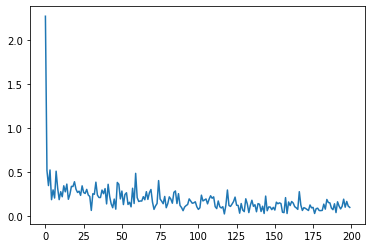

In [14]:
train_loss = []
for epoch in range(num_epoches):
    train(epoch)
    test()
plt.plot(train_loss)

In [15]:
def classify(img_path):
    img = Image.open(img_path)
    img = img.convert('L').resize((28, 28))
    plt.imshow(img)
    out = net(data_transform(img).unsqueeze(0).cuda())
    _, pred = torch.max(out, 1)
    pred = trainset.classes[pred]
    print(pred)

Bag


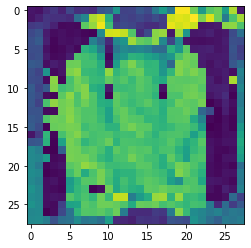

In [16]:
classify('cloth.jpg')